# Applie Statistics Project 

Workflow

1. Processing
    • Focus on last 2 or 5 years
    • Consider only the pool where all the zones are present
2. Exploratory Data Analysis
    • Treat hours separately (so consider daily time series)
    • Look at similarities within day type, month
3. Functional Data Analysis
    • Smoothing
    • Functional Principal Component Analysis
    • K-means
4. Correlation with external variables (Gas price, load and renewable generation forecast)
5. Functional (Auto)Regression models



In [2]:
#import libraries 

import pandas as pd
pd.options.mode.chained_assignment = None

import gzip
import pickle
from io import BytesIO
import plotly.express as px
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import os
from os.path import join
from ydata_profiling import ProfileReport

import numpy as np
from numpy.polynomial.polynomial import Polynomial

from scipy.stats import gaussian_kde
import statsmodels.api as sm

#GP imputation 
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, ExpSineSquared, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

from itertools import product


#functional data analysis
import skfda
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,

)
from skfda.representation.grid import FDataGrid

In [ ]:
#constant definition 

In [83]:
#helper function definition 

#function to convert data and time formats and create a column that contain both values in datetime format
def converti_data_ora(row):
    data_str = str(row['Data'])
    ora_str = str(row['Ora']-1)  # -1 because the range time is from 0 to 23 so ex. hour 1 corresponds to 00:00
    data_ora_str = data_str[:4] + '-' + data_str[4:6] + '-' + data_str[6:] + ' ' + ora_str + ':00:00'
    return datetime.strptime(data_ora_str, '%Y-%m-%d %H:%M:%S')


# Polynomial smoothing
def smooth_series(series, degree=2):
    y = series.values
    mask = ~np.isnan(y)
    coefs = Polynomial.fit(x[mask], y[mask], deg=degree)
    return coefs(x)

# LOESS smoothing 
def apply_loess(series, frac=0.3):
    lowess = sm.nonparametric.lowess # LOESS smoothing
    smoothed_values = lowess(series, series.index, frac=frac, return_sorted=False) # The series index is numeric and represents hours
    return smoothed_values

## Processing and Exploration

### Data Loading

In [ ]:
####  using ts_df.pkl.gz 

YEAR = 2023
path = r'C:\Users\bartama\Desktop\PoliMi Stuff\Applied Statistics\Data\dataa\\'
file = 'ts_df.pkl.gz'

with gzip.open(path+file, 'rb') as f:
    loaded_df = pd.read_pickle(f)

# Getting Values from a specific year that can be choose with YEAR constant

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d')
loaded_df = loaded_df.loc[loaded_df['Data'].dt.year == YEAR,:]

In [117]:
market = 'MGP'
dataset = 'DomandaOfferta'
date_range = pd.date_range(start='2022-01-01', end='2023-12-31')

df_list = []

for date in tqdm(date_range):   #iterate in the range specified before 
    
    date = date.strftime('%Y%m%d') #ex. 2019-01-01 --> 20190101
    file_path = join('data', market +'_'+ dataset, str(date) + market + dataset + '.xml') #file path = data/MGP_DomandaOfferta/20190101DomandaOfferta
    
    if not(os.path.exists(file_path)):      #check correct path existance
        print(f"{file_path} not found")
    else:
        df = pd.read_xml(file_path, xpath=f'./{dataset}')  #read xml file and w in df 
    df_list.append(df)

loaded_df = pd.concat(df_list, ignore_index=True)  #create a unique dataframe 
loaded_df

  0%|          | 0/730 [00:00<?, ?it/s]

Data  Ora Mercato  \
0        20220101    1     MGP   
1        20220101    1     MGP   
2        20220101    1     MGP   
3        20220101    1     MGP   
4        20220101    1     MGP   
...           ...  ...     ...   
6153398  20231231   24     MGP   
6153399  20231231   24     MGP   
6153400  20231231   24     MGP   
6153401  20231231   24     MGP   
6153402  20231231   24     MGP   

                                               ZonaMercato  PrezzoZonale  \
0        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
1        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
2        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
3        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
4        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
...                                                    ...           ...   
6153398  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153399  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153400  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153401  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153402  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   

          Quantita   Prezzo Tipo  
0        70000.000  3000.00  OFF  
1            1.200  1500.00  OFF  
2          125.000  1000.00  OFF  
3          101.000   909.32  OFF  
4          105.000   905.62  OFF  
...            ...      ...  ...  
6153398      0.007     0.00  BID  
6153399     50.000    -0.27  BID  
6153400      9.000    -3.01  BID  
6153401     54.000  -100.00  BID  
6153402      0.020  -499.00  BID  

[6153403 rows x 8 columns]

In [118]:
#saving loaded_df in a pickle file in order to use it in the future without downloading the data again

with open('loaded_df.pickle', 'wb') as f:
    pickle.dump(loaded_df, f)  # Salva il DataFrame utilizzando il modulo pickle


In [8]:
# Per Pickle
with open('loaded_df.pickle', 'rb') as f:
    loaded_df = pickle.load(f)

### Exploration 

In [119]:
loaded_df

Data  Ora Mercato  \
0        20220101    1     MGP   
1        20220101    1     MGP   
2        20220101    1     MGP   
3        20220101    1     MGP   
4        20220101    1     MGP   
...           ...  ...     ...   
6153398  20231231   24     MGP   
6153399  20231231   24     MGP   
6153400  20231231   24     MGP   
6153401  20231231   24     MGP   
6153402  20231231   24     MGP   

                                               ZonaMercato  PrezzoZonale  \
0        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
1        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
2        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
3        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
4        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
...                                                    ...           ...   
6153398  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153399  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153400  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153401  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153402  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   

          Quantita   Prezzo Tipo  
0        70000.000  3000.00  OFF  
1            1.200  1500.00  OFF  
2          125.000  1000.00  OFF  
3          101.000   909.32  OFF  
4          105.000   905.62  OFF  
...            ...      ...  ...  
6153398      0.007     0.00  BID  
6153399     50.000    -0.27  BID  
6153400      9.000    -3.01  BID  
6153401     54.000  -100.00  BID  
6153402      0.020  -499.00  BID  

[6153403 rows x 8 columns]

In [120]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6153403 entries, 0 to 6153402
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Data          int64  
 1   Ora           int64  
 2   Mercato       object 
 3   ZonaMercato   object 
 4   PrezzoZonale  float64
 5   Quantita      float64
 6   Prezzo        float64
 7   Tipo          object 
dtypes: float64(3), int64(2), object(3)
memory usage: 375.6+ MB


In [103]:

PROFILE = ProfileReport(loaded_df, title=" Profiling Report")
PROFILE


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [104]:
#saving the profile report in a html file in order to visualize it in a more user-friendly way 
PROFILE.to_file("profile_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#load the saved profile report
PROFILE = ProfileReport.load("profile_report.html")

### Processing

In [133]:
loaded_df

Data  Ora Mercato  \
0        20220101    1     MGP   
1        20220101    1     MGP   
2        20220101    1     MGP   
3        20220101    1     MGP   
4        20220101    1     MGP   
...           ...  ...     ...   
6153398  20231231   24     MGP   
6153399  20231231   24     MGP   
6153400  20231231   24     MGP   
6153401  20231231   24     MGP   
6153402  20231231   24     MGP   

                                               ZonaMercato  PrezzoZonale  \
0        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
1        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
2        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
3        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
4        CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;CORS;FR...        170.28   
...                                                    ...           ...   
6153398  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153399  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153400  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153401  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   
6153402  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...        106.12   

          Quantita   Prezzo Tipo  
0        70000.000  3000.00  OFF  
1            1.200  1500.00  OFF  
2          125.000  1000.00  OFF  
3          101.000   909.32  OFF  
4          105.000   905.62  OFF  
...            ...      ...  ...  
6153398      0.007     0.00  BID  
6153399     50.000    -0.27  BID  
6153400      9.000    -3.01  BID  
6153401     54.000  -100.00  BID  
6153402      0.020  -499.00  BID  

[6153403 rows x 8 columns]

In [134]:
loaded_df.Ora.value_counts()

Ora
12    277885
15    275484
14    275128
13    274633
11    272485
16    271818
17    267443
10    266593
19    262382
20    262334
18    262015
21    260791
9     258541
22    258038
23    253863
24    250185
8     249648
7     239650
1     236899
3     236107
6     235891
2     235352
5     235077
4     234618
25       543
Name: count, dtype: int64

In [137]:
# delete rows where hour is 25
loaded_df = loaded_df[loaded_df.Ora != 25]

In [139]:
#select only the pool where all zanes are present so the situation in which all zones collaborate in a unique market 

loaded_df = loaded_df.loc[loaded_df.ZonaMercato=='CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CORS;FRAN;GREC;SLOV;SVIZ;MALT;COUP;MONT;',:]


In [140]:
loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
loaded_df['Ora'] = (loaded_df['Ora'] - 1).astype(str).str.zfill(2) + ':00:00'

loaded_df['DataOra'] = pd.to_datetime(loaded_df['Data'] + ' ' + loaded_df['Ora'])

In [ ]:
# rename columns to English

column_mapping = {'Data': 'Day', 'Ora': 'Hour',"Mercato":"Market", 'ZonaMercato': 'MarketArea', 'PrezzoZonale': 'ZonalPrice', 'Quantita': 'Quantity', 'Prezzo': 'Price', 'Tipo': 'Type', "DataOra": "Date"}


loaded_df.rename(columns=column_mapping, inplace=True)

In [143]:
# looking for duplicates rows
duplicate_row = loaded_df[loaded_df.duplicated()]
duplicate_row.value_counts()


Series([], Name: count, dtype: int64)

In [146]:
loaded_df

Day      Hour Market  \
2525     2022-01-01  07:00:00    MGP   
2526     2022-01-01  07:00:00    MGP   
2527     2022-01-01  07:00:00    MGP   
2528     2022-01-01  07:00:00    MGP   
2529     2022-01-01  07:00:00    MGP   
...             ...       ...    ...   
6153398  2023-12-31  23:00:00    MGP   
6153399  2023-12-31  23:00:00    MGP   
6153400  2023-12-31  23:00:00    MGP   
6153401  2023-12-31  23:00:00    MGP   
6153402  2023-12-31  23:00:00    MGP   

                                                MarketArea  ZonalPrice  \
2525     CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...       99.99   
2526     CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...       99.99   
2527     CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...       99.99   
2528     CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...       99.99   
2529     CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...       99.99   
...                                                    ...         ...   
6153398  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...      106.12   
6153399  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...      106.12   
6153400  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...      106.12   
6153401  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...      106.12   
6153402  CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...      106.12   

          Quantity    Price Type                Date  
2525     70000.000  3000.00  OFF 2022-01-01 07:00:00  
2526         1.200  1500.00  OFF 2022-01-01 07:00:00  
2527       195.000  1000.00  OFF 2022-01-01 07:00:00  
2528       101.000   909.32  OFF 2022-01-01 07:00:00  
2529       105.000   905.62  OFF 2022-01-01 07:00:00  
...            ...      ...  ...                 ...  
6153398      0.007     0.00  BID 2023-12-31 23:00:00  
6153399     50.000    -0.27  BID 2023-12-31 23:00:00  
6153400      9.000    -3.01  BID 2023-12-31 23:00:00  
6153401     54.000  -100.00  BID 2023-12-31 23:00:00  
6153402      0.020  -499.00  BID 2023-12-31 23:00:00  

[3523855 rows x 9 columns]

In [145]:
# saved datafram preprocess_df in a pickle file in order to use it in the future without reprocessing the data
with open('preprocess_df.pickle', 'wb') as f:
    pickle.dump(loaded_df, f)  

In [3]:
#load the saved preprocess_df
with open('preprocess_df.pickle', 'rb') as f:
    loaded_df = pickle.load(f)

In [4]:
columns_wanted = ['Date', 'ZonalPrice', 'Quantity','Price']

## BID

In [5]:


bid = loaded_df.loc[loaded_df.Type == "BID",columns_wanted]
bid_df = bid.copy()
bid.Price = bid.Price *-1 ## for bid prices, take the negative of it
bid = bid.sort_values(by=['Price']).reset_index(drop = True) # sort in ascending way
bid['Cumulative Quantity'] = bid.Quantity.cumsum()


ask = loaded_df.loc[loaded_df.Type == "OFF",columns_wanted]
ask_df = ask.copy()
ask = ask.sort_values(by=['Price']).reset_index(drop = True)
ask['Cumulative Quantity'] = ask.Quantity.cumsum()

In [6]:
#salva bid_df e ask_df in un file pickle per utilizzarli in futuro senza doverli ricalcolare
with open('bid_df.pickle', 'wb') as f:
    pickle.dump(bid_df, f)

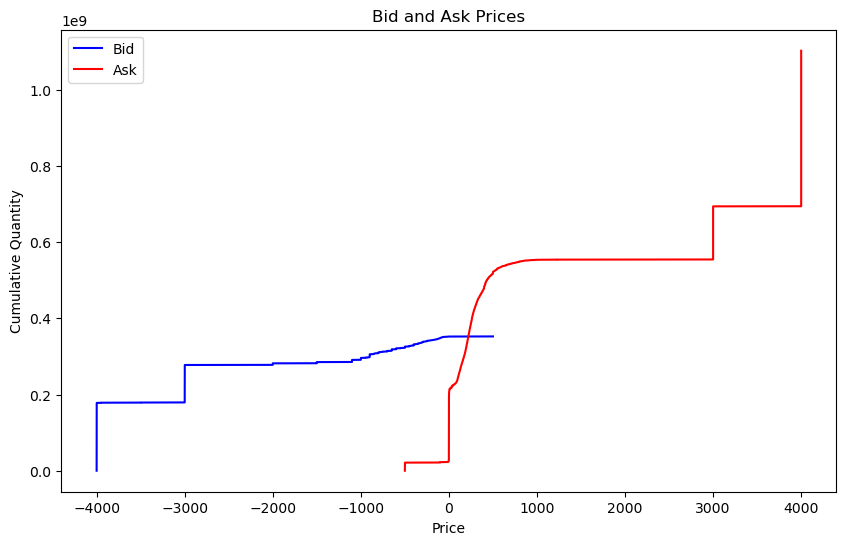

In [7]:
#plot similarities between bid and ask prices
plt.figure(figsize=(10,6))
plt.plot(bid['Price'], bid['Cumulative Quantity'], label='Bid', color='blue')
plt.plot(ask['Price'], ask['Cumulative Quantity'], label='Ask', color='red')
plt.xlabel('Price')
plt.ylabel('Cumulative Quantity')
plt.title('Bid and Ask Prices')
plt.legend()
plt.show()

### BID

In [120]:
bid_df

Date  ZonalPrice   Quantity    Price
2840    2022-01-01 07:00:00       99.99  18775.156  3000.00
2841    2022-01-01 07:00:00       99.99      7.114  2999.00
2842    2022-01-01 07:00:00       99.99      2.526  2000.00
2843    2022-01-01 07:00:00       99.99    162.000  1000.00
2844    2022-01-01 07:00:00       99.99    267.513   800.00
...                     ...         ...        ...      ...
6153398 2023-12-31 23:00:00      106.12      0.007     0.00
6153399 2023-12-31 23:00:00      106.12     50.000    -0.27
6153400 2023-12-31 23:00:00      106.12      9.000    -3.01
6153401 2023-12-31 23:00:00      106.12     54.000  -100.00
6153402 2023-12-31 23:00:00      106.12      0.020  -499.00

[958140 rows x 4 columns]

/Users/luca.distefano/opt/anaconda3/envs/as/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luca.distefano/opt/anaconda3/envs/as/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


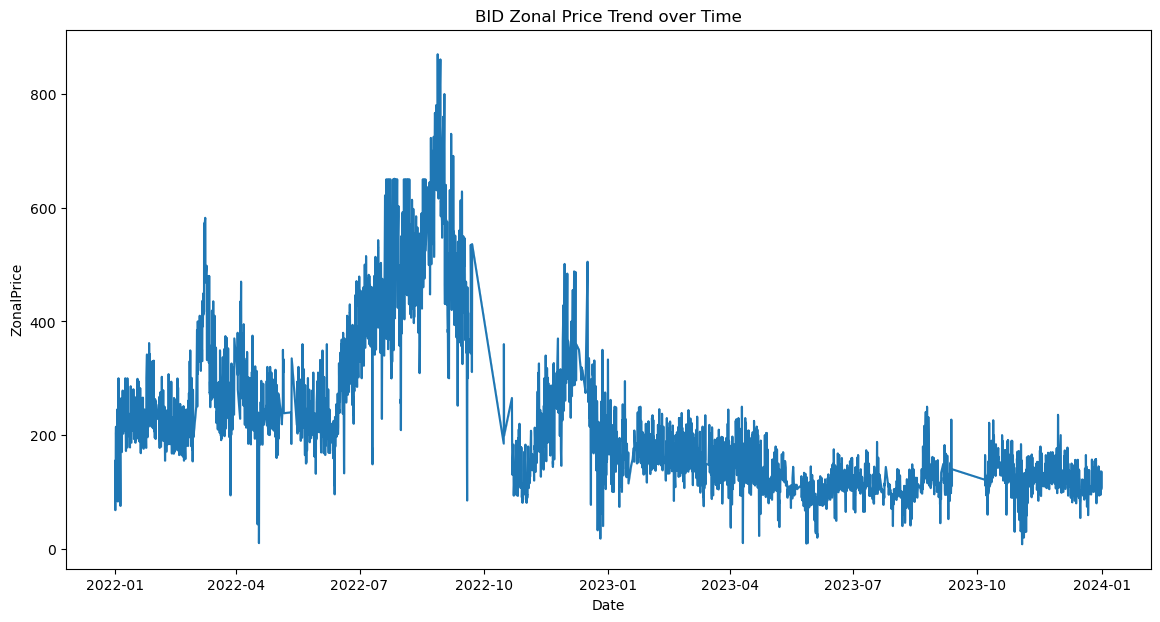

In [153]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='ZonalPrice', data=bid_df)
plt.title('BID Zonal Price Trend over Time')
plt.show()

In [154]:
# Extract hours and days of the week
bid_df['hour'] = bid_df['Date'].dt.hour
bid_df['day_week'] = bid_df['Date'].dt.dayofweek

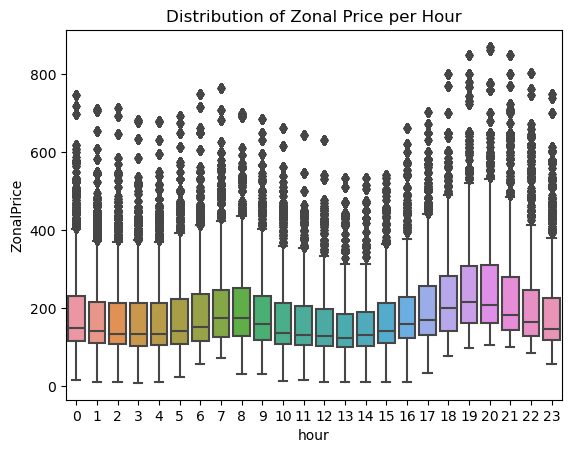

In [155]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

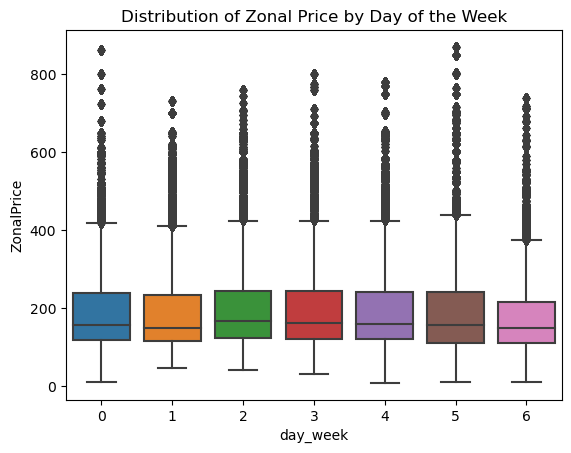

In [156]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

In [2]:
bid_df

NameError: name 'bid_df' is not defined

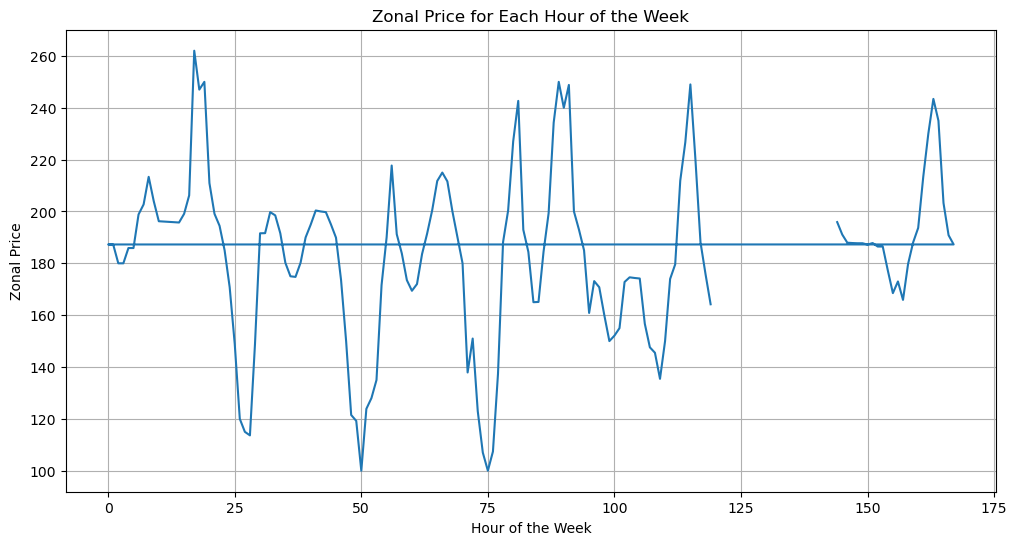

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Date' column is not in datetime format
# Convert it to datetime
bid_df['Date'] = pd.to_datetime(bid_df['Date'])

# Extract hour from the 'Date' column
bid_df['Hour'] = bid_df['Date'].dt.hour

# Filter data for a single week
start_date = '2023-01-01'
end_date = '2023-01-07'
week_data = bid_df[(bid_df['Date'] >= start_date) & (bid_df['Date'] < end_date)]

# Create a continuous function for zonal prices for each hour of the week
plt.figure(figsize=(12, 6))

# Plot zonal price against hours for the entire week
plt.plot(week_data['Hour'] + ((week_data['Date'].dt.dayofweek % 7) * 24), week_data['ZonalPrice'])

plt.xlabel('Hour of the Week')
plt.ylabel('Zonal Price')
plt.title('Zonal Price for Each Hour of the Week')

plt.grid(True)
plt.show()



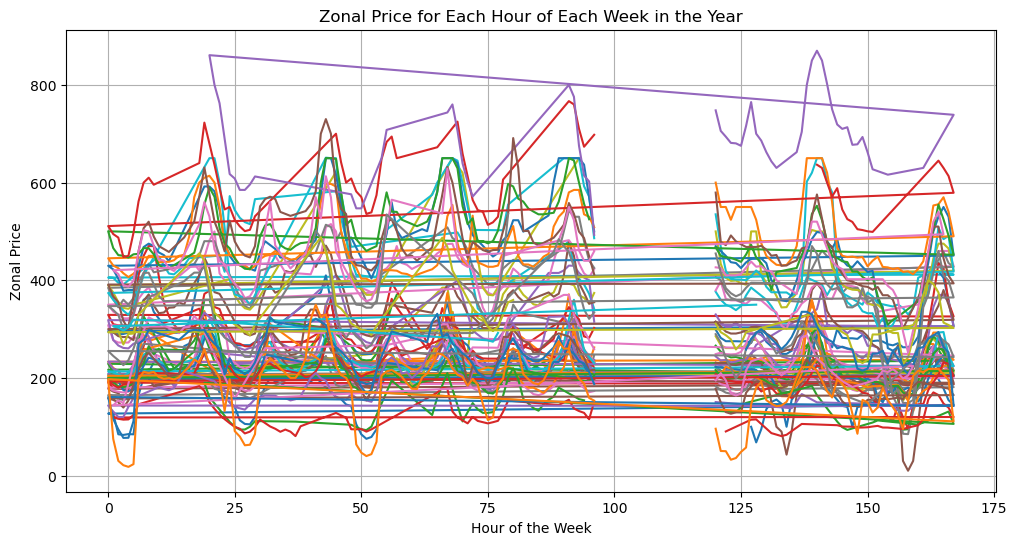

In [211]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Date' column is not in datetime format
# Convert it to datetime
bid_df['Date'] = pd.to_datetime(bid_df['Date'])

# Extract hour from the 'Date' column
bid_df['Hour'] = bid_df['Date'].dt.hour

# Create an empty figure
plt.figure(figsize=(12, 6))

# Iterate over each week of the year
for week in range(1, 53):
    # Filter data for the current week
    start_date = pd.Timestamp(year=bid_df['Date'].iloc[0].year, month=1, day=1) + pd.DateOffset(weeks=(week - 1))
    end_date = start_date + pd.DateOffset(days=6)
    week_data = bid_df[(bid_df['Date'] >= start_date) & (bid_df['Date'] <= end_date)]

    # Plot the zonal price against hours for the entire week
    plt.plot(week_data['Hour'] + ((week_data['Date'].dt.dayofweek % 7) * 24), week_data['ZonalPrice'], label=f'Week {week}')

# Add labels and title
plt.xlabel('Hour of the Week')
plt.ylabel('Zonal Price')
plt.title('Zonal Price for Each Hour of Each Week in the Year')


# Show grid
plt.grid(True)

# Show plot
plt.show()


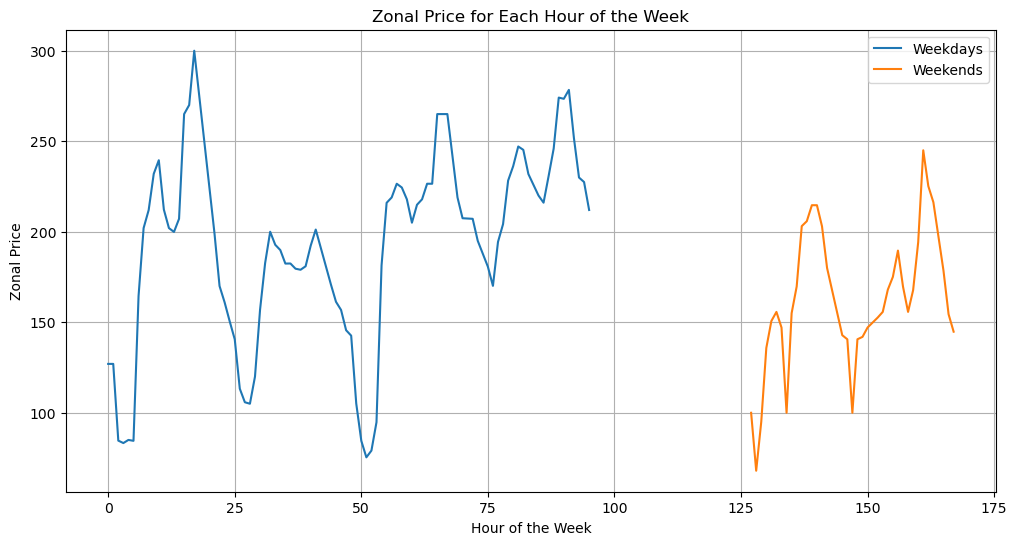

In [208]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Date' column is not in datetime format
# Convert it to datetime
bid_df['Date'] = pd.to_datetime(bid_df['Date'])

# Extract hour from the 'Date' column
bid_df['Hour'] = bid_df['Date'].dt.hour

# Filter data for a single week
start_date = '2022-01-01'
end_date = '2022-01-07'
week_data = bid_df[(bid_df['Date'] >= start_date) & (bid_df['Date'] < end_date)]

# Divide the week data into two parts: Monday to Friday and Saturday to Sunday
weekend_mask = (week_data['Date'].dt.dayofweek >= 5)  # Saturday and Sunday
weekday_mask = ~weekend_mask  # Monday to Friday

weekend_data = week_data[weekend_mask]
weekday_data = week_data[weekday_mask]

# Plot the zonal price against hours for each part of the week
plt.figure(figsize=(12, 6))

plt.plot(weekday_data['Hour'] + (weekday_data['Date'].dt.dayofweek * 24), weekday_data['ZonalPrice'], label='Weekdays')
plt.plot(weekend_data['Hour'] + (weekend_data['Date'].dt.dayofweek * 24), weekend_data['ZonalPrice'], label='Weekends')

plt.xlabel('Hour of the Week')
plt.ylabel('Zonal Price')
plt.title('Zonal Price for Each Hour of the Week')

plt.legend()
plt.grid(True)
plt.show()


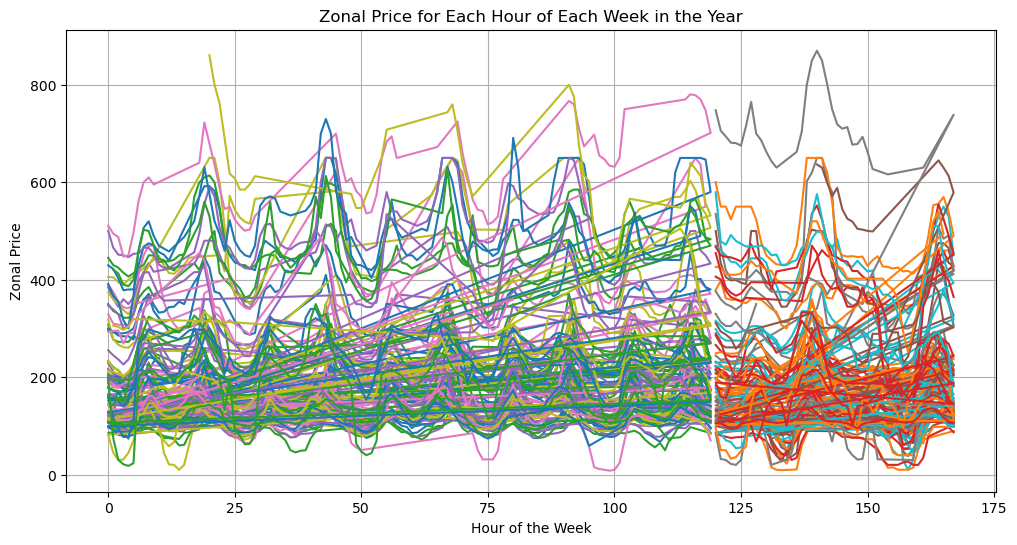

In [218]:
# Extract hour from the 'Date' column
bid_df['Hour'] = bid_df['Date'].dt.hour

# Create an empty figure
plt.figure(figsize=(12, 6))

# Iterate over each week of the year
for week in range(1, 53):
    # Filter data for the current week
    week_data = bid_df[bid_df['Date'].dt.isocalendar().week == week]

    # Divide the week data into two parts: Monday to Friday and Saturday to Sunday
    weekend_mask = (week_data['Date'].dt.dayofweek >= 5)  # Saturday and Sunday
    weekday_mask = ~weekend_mask  # Monday to Friday

    weekend_data = week_data[weekend_mask]
    weekday_data = week_data[weekday_mask]

    # Plot the zonal price against hours for each part of the week
    plt.plot(weekday_data['Hour'] + (weekday_data['Date'].dt.dayofweek * 24), weekday_data['ZonalPrice'], label=f'Week {week} - Weekdays')
    plt.plot(weekend_data['Hour'] + (weekend_data['Date'].dt.dayofweek * 24), weekend_data['ZonalPrice'], label=f'Week {week} - Weekends')

# Add labels and title
plt.xlabel('Hour of the Week')
plt.ylabel('Zonal Price')
plt.title('Zonal Price for Each Hour of Each Week in the Year')

# Show grid
plt.grid(True)

# Show plot
plt.show()


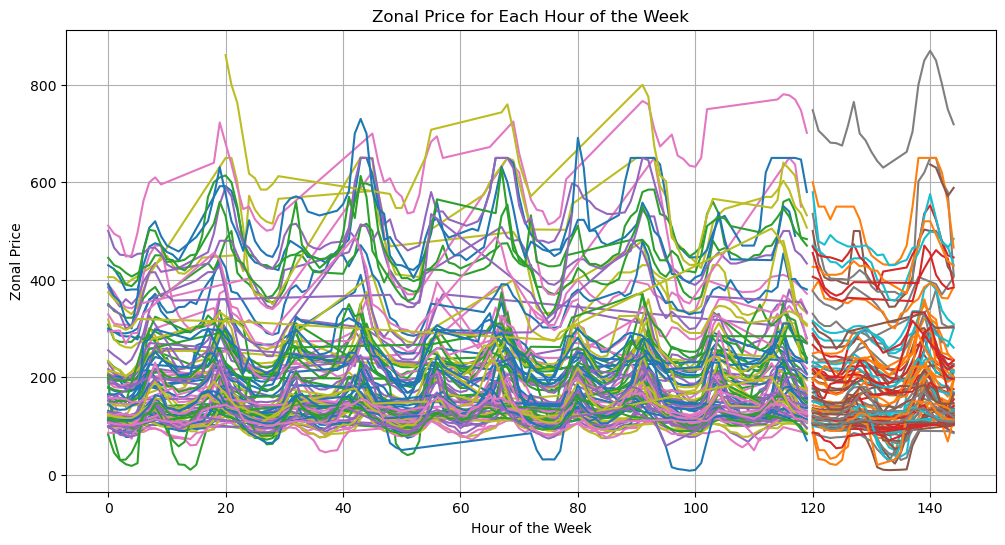

In [228]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Date' column is not in datetime format
# Convert it to datetime
bid_df['Date'] = pd.to_datetime(bid_df['Date'])

# Extract hour from the 'Date' column
bid_df['Hour'] = bid_df['Date'].dt.hour

# Generate start dates for each week of the year
start_dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='W-MON')

plt.figure(figsize=(12, 6))

# Iterate over each week
for start_date in start_dates:
    end_date = start_date + pd.DateOffset(days=6)
    
    # Filter data for the current week
    week_data = bid_df[(bid_df['Date'] >= start_date) & (bid_df['Date'] <= end_date)]
    
    # Divide the week data into two parts: Monday to Friday and Saturday to Sunday
    weekend_mask = (week_data['Date'].dt.dayofweek >= 5)  # Saturday and Sunday
    weekday_mask = ~weekend_mask  # Monday to Friday

    weekend_data = week_data[weekend_mask]
    weekday_data = week_data[weekday_mask]

    # Plot the zonal price against hours for each part of the week
    plt.plot(weekday_data['Hour'] + (weekday_data['Date'].dt.dayofweek * 24), weekday_data['ZonalPrice'], label='Weekdays')
    plt.plot(weekend_data['Hour'] + (weekend_data['Date'].dt.dayofweek * 24), weekend_data['ZonalPrice'], label='Weekends')

plt.xlabel('Hour of the Week')
plt.ylabel('Zonal Price')
plt.title('Zonal Price for Each Hour of the Week')

plt.grid(True)
plt.show()

curves for 2022 and 2023

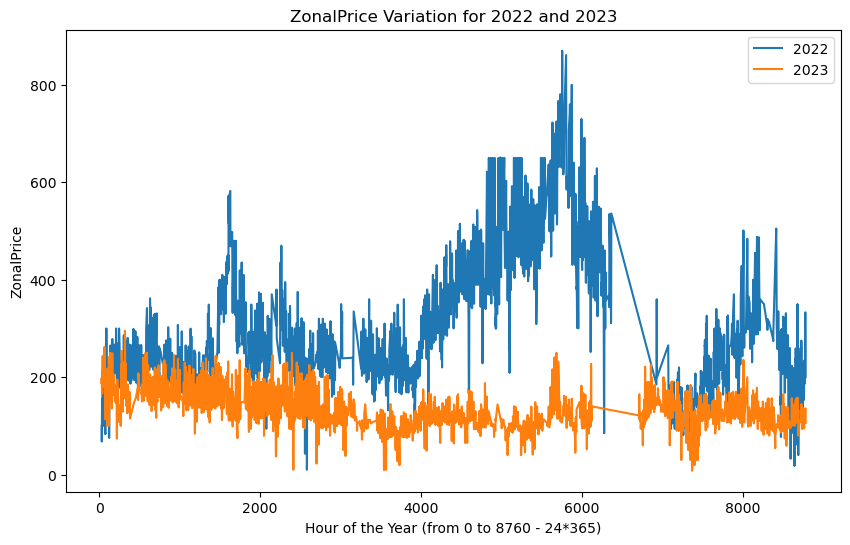

In [16]:

# Extract year, hour, and ZonalPrice columns
bid_df['Year'] = bid_df['Date'].dt.year
bid_df['Hour_of_year'] = bid_df['Date'].dt.dayofyear * 24 + bid_df['Date'].dt.hour

# Filter data for years 2022 and 2023
data_2022 = bid_df[bid_df['Year'] == 2022]
data_2023 = bid_df[bid_df['Year'] == 2023]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_2022['Hour_of_year'], data_2022['ZonalPrice'], label='2022')
plt.plot(data_2023['Hour_of_year'], data_2023['ZonalPrice'], label='2023')
plt.xlabel('Hour of the Year (from 0 to 8760 - 24*365)')
plt.ylabel('ZonalPrice')
plt.title('ZonalPrice Variation for 2022 and 2023')
plt.legend()

# Set limits for the x-axis
#plt.xlim(0, 24*365)

plt.show()




# FDA from R

## smoothing methods 

In [ ]:
#load bid_df
with open('bid_df.pickle', 'rb') as f:
    bid_df = pickle.load(f)

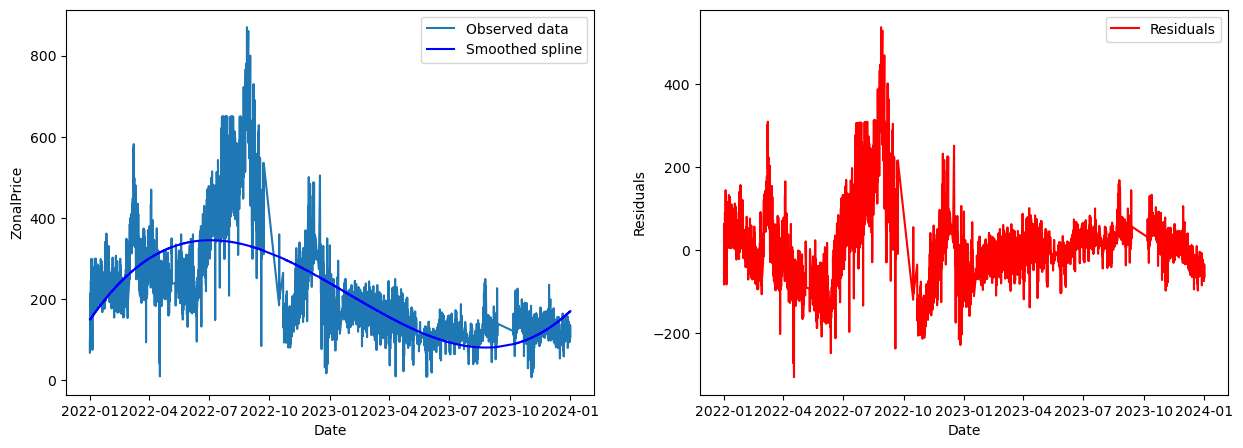

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Estrai le colonne che ti interessano
abscissa = pd.to_datetime(bid_df['Date'])
Xobs0 = bid_df['ZonalPrice']

# Calcola il numero di giorni trascorsi dalla data minima
abscissa_days = (abscissa - abscissa.min()).dt.days

# Definisci il numero di nodi per la spline cubica
m = 4

# Crea la matrice dei nodi
breaks = np.linspace(abscissa_days.min(), abscissa_days.max(), m)

# Definisci il modello di smoothing spline
gam = LinearGAM(s(0, n_splines=m)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)

# Valuta il modello
Xss0 = gam.predict(abscissa_days)

# Plot dei risultati
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(abscissa, Xobs0, label='Observed data')
plt.plot(abscissa, Xss0, label='Smoothed spline', color='blue')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(abscissa, Xobs0 - Xss0, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.show()



In [76]:
## change lambda: 1e-5
gam = LinearGAM(s(0, n_splines=m, lam=1e-5)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)
Xss0 = gam.predict(abscissa_days)


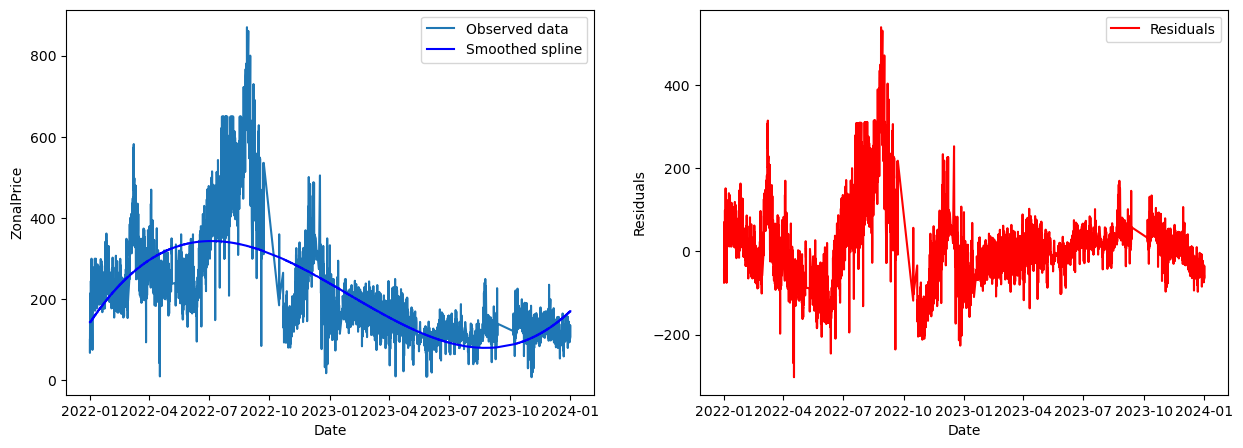

In [77]:
#plot results with this lambda as before
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(abscissa, Xobs0, label='Observed data')
plt.plot(abscissa, Xss0, label='Smoothed spline', color='blue')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(abscissa, Xobs0 - Xss0, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.show()

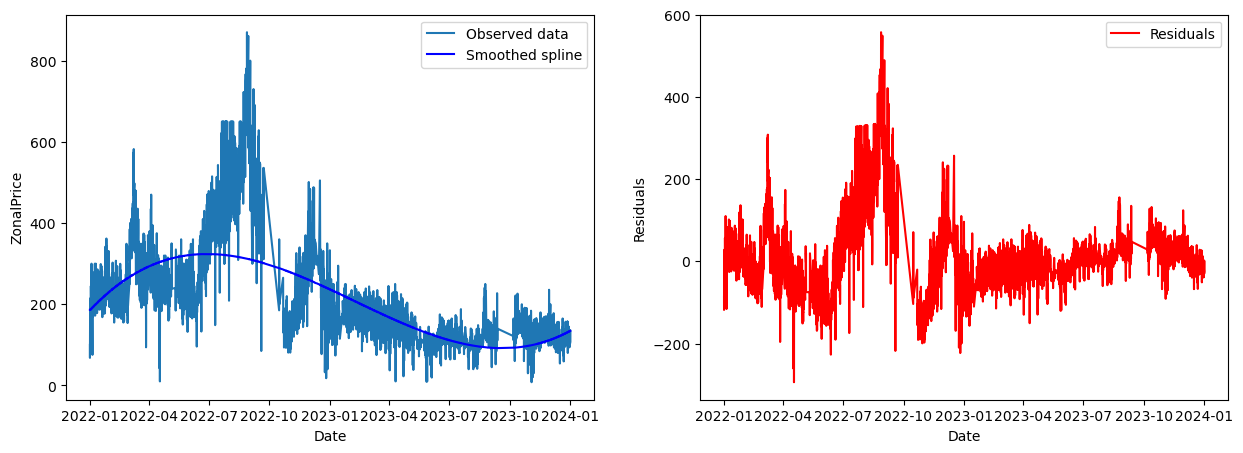

In [81]:
# change lambda: 1e-12
gam = LinearGAM(s(0, n_splines=m, lam=1e-12)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)
Xss0 = gam.predict(abscissa_days)

#plot results with this lambda as before
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(abscissa, Xobs0, label='Observed data')
plt.plot(abscissa, Xss0, label='Smoothed spline', color='blue')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(abscissa, Xobs0 - Xss0, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.show()

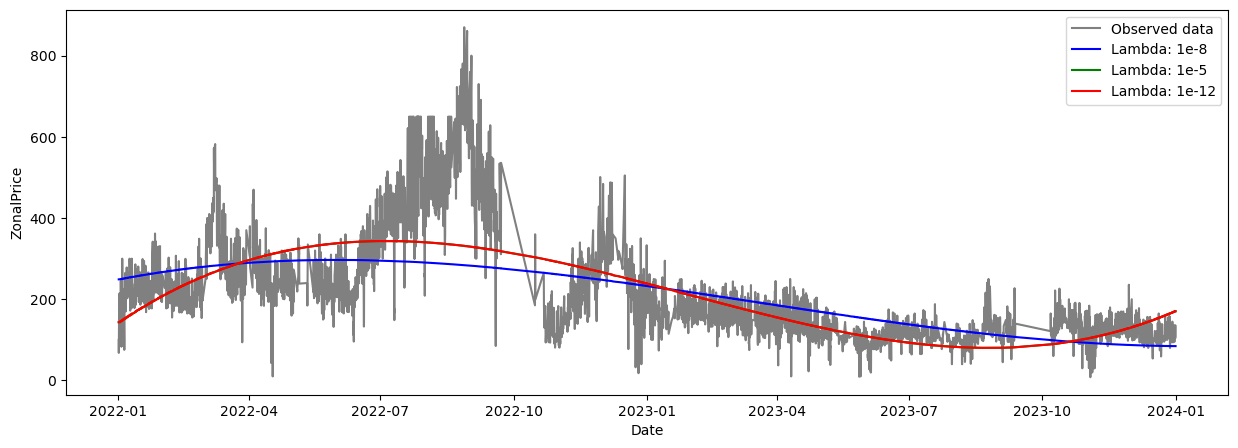

In [112]:
from pygam import LinearGAM, s

# Estrai le colonne che ti interessano
abscissa = pd.to_datetime(bid_df['Date'])
Xobs0 = bid_df['ZonalPrice']

# Calcola il numero di giorni trascorsi dalla data minima
abscissa_days = (abscissa - abscissa.min()).dt.days

# Definisci il numero di nodi per la spline cubica
m = 4

# Crea la matrice dei nodi
breaks = np.linspace(abscissa_days.min(), abscissa_days.max(), m)

# Definisci il modello di smoothing spline con lambda: 1e-8
gam_lambda_8 = LinearGAM(s(0, n_splines=m)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)

# Valuta il modello con lambda: 1e-8
Xss0_lambda_8 = gam_lambda_8.predict(abscissa_days)

# Cambia lambda: 1e-5
gam_lambda_5 = LinearGAM(s(0, n_splines=m, lam=1e-10)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)
Xss0_lambda_5 = gam_lambda_5.predict(abscissa_days)

# Cambia lambda: 1e-12
gam_lambda_12 = LinearGAM(s(0, n_splines=m, lam=1e-12)).fit(abscissa_days.values.reshape(-1, 1), Xobs0)
Xss0_lambda_12 = gam_lambda_12.predict(abscissa_days)

# Plot dei risultati
plt.figure(figsize=(15, 5))

plt.plot(abscissa, Xobs0, label='Observed data', color='grey')
plt.plot(abscissa, Xss0_lambda_8, label='Lambda: 1e-8', color='blue')
plt.plot(abscissa, Xss0_lambda_5, label='Lambda: 1e-5', color='green')
plt.plot(abscissa, Xss0_lambda_12, label='Lambda: 1e-12', color='red')

plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.show()


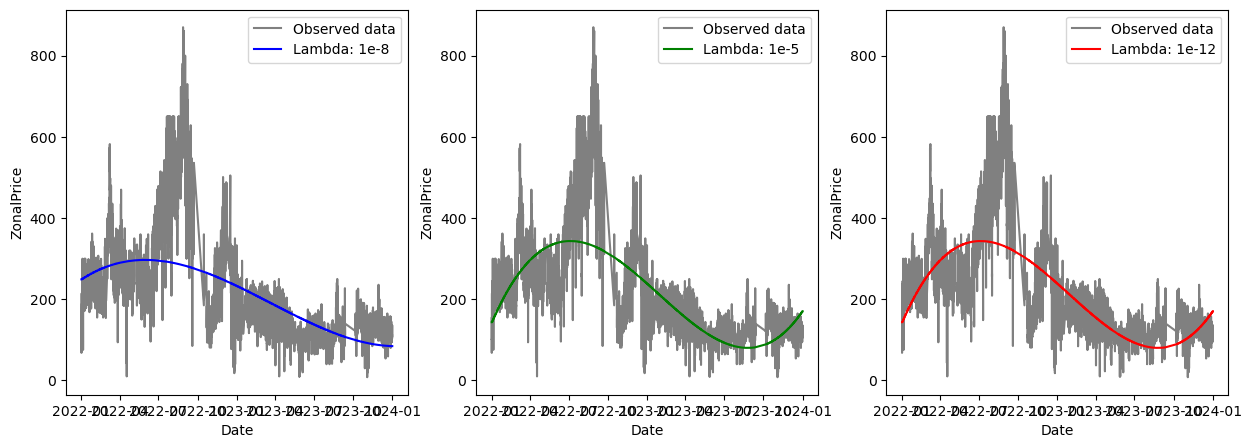

In [113]:
#sulla stessa riga un plot per ogni lambda
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(abscissa, Xobs0, label='Observed data', color='grey')
plt.plot(abscissa, Xss0_lambda_8, label='Lambda: 1e-8', color='blue')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(abscissa, Xobs0, label='Observed data', color='grey')
plt.plot(abscissa, Xss0_lambda_5, label='Lambda: 1e-5', color='green')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(abscissa, Xobs0, label='Observed data', color='grey')
plt.plot(abscissa, Xss0_lambda_12, label='Lambda: 1e-12', color='red')
plt.xlabel('Date')
plt.ylabel('ZonalPrice')
plt.legend()

plt.show()

# K Means 

Anomaly Detection: K-means could be used to identify anomalous price offers or unusual behaviors in the electricity market. For instance, you could find clusters of price offers that significantly deviate from the general market trends, which could indicate fraudulent behaviors or data errors.

In [ ]:
#load bid_df
with open('bid_df.pickle', 'rb') as f:
    bid_df = pickle.load(f)

/Users/luca.distefano/opt/anaconda3/envs/as/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


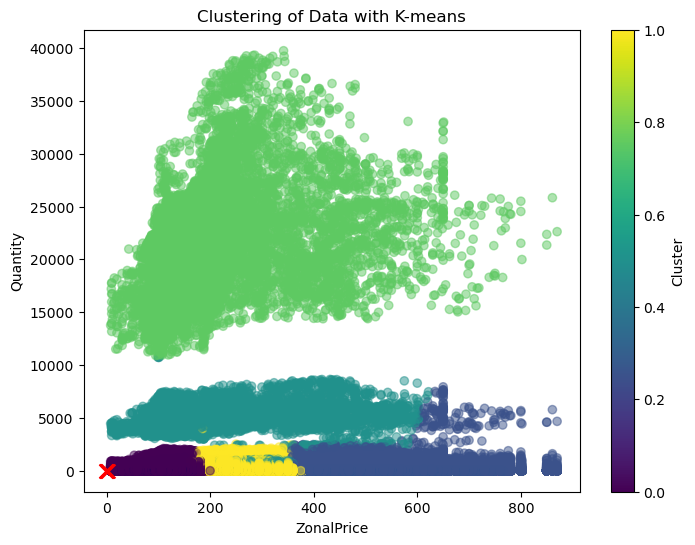

Number of identified anomalies: 147
Details of anomalies:


Date  ZonalPrice   Quantity   Price
119073 2022-01-12 15:00:00   240.00793  37255.156  3000.0
120539 2022-01-12 18:00:00   285.96912  39323.380  3000.0
120985 2022-01-12 19:00:00   269.02943  38458.007  3000.0
121434 2022-01-12 20:00:00   246.90000  36174.791  3000.0
126491 2022-01-13 08:00:00   252.39000  37231.927  3000.0
...                    ...         ...        ...     ...
750961 2022-03-14 19:00:00   435.42000  36637.444  3000.0
759981 2022-03-15 19:00:00   410.00000  36138.334  3000.0
812742 2022-03-21 19:00:00   336.98382  36511.402  3000.0
821876 2022-03-22 19:00:00   351.00000  36678.968  3000.0
830636 2022-03-23 19:00:00   374.14000  36036.192  3000.0

[147 rows x 4 columns]

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Data Preparation
data = bid_df[['ZonalPrice', 'Quantity', 'Price']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 2. Choosing the number of clusters (e.g., K=5)
num_clusters = 5

# 3. Applying K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)
clusters = kmeans.predict(scaled_data)

# 4. Calculate distances between data points and cluster centroids
centroid_distances = kmeans.transform(scaled_data)

# 5. Calculate the percentile of distances
percentile_threshold = np.percentile(centroid_distances, 99.99)

# 6. Set the threshold
threshold = percentile_threshold

# 7. Identifying anomalies
anomalies_indices = np.where(np.max(centroid_distances, axis=1) > threshold)
anomalies = bid_df.iloc[anomalies_indices]

# 8. Visualizing the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(data['ZonalPrice'], data['Quantity'], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.xlabel('ZonalPrice')
plt.ylabel('Quantity')
plt.title('Clustering of Data with K-means')
plt.colorbar(label='Cluster')
plt.show()

# 9. Visualizing anomalies
print("Number of identified anomalies:", len(anomalies))
print("Details of anomalies:")
anomalies
